In [57]:
# Import libraries
import yfinance as yf
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input, Lambda
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import shap
from windowshap import StationaryWindowSHAP

# Set seeds for reproducibility
np.random.seed(7) # For NumPy
tf.random.set_seed(7) # For TensorFlow

In [ ]:
# Setting (hyper)parameters and other variables
tickers_list = ['JNJ', 'NVDA', 'META', 'GOOGL']
seq_length = 60 # monthly = 30, quarterly = 90, yearly = 365
n_batch_size = 32 # As in SHAP example
n_epochs = 5 # As in SHAP example = 15
# LEARNING_RATE = 0.001
train_split = 0.8

sample_start_date = "2012-06-01" # META had missing values up to  2012-05-17
sample_end_date = "2025-05-01"
included_features = ['Open', 'Close', 'High', 'Low', 'Volume']

n_nodes = 128
dropout_rate = 0.2
recurrent_dropout_rate = 0.2

In [59]:
## Prepare data

# Download stock data (daily)
def get_stock_data(ticker):
    df = yf.download(ticker, start=sample_start_date, end=sample_end_date, group_by='column')
    return df[included_features]

print("Downloading data...")
data_map = {ticker: get_stock_data(ticker) for ticker in tickers_list}

for ticker in data_map:
    df = data_map[ticker]

    # Flatten multi-index if needed
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    df.columns.name = None

    data_map[ticker] = df

# Normalize each ticker separately
print("Normalizing data...")

scalers = {}
scaled_data_map = {}

for ticker in tickers_list:
    df = data_map[ticker]  # original unscaled data

    scaler = RobustScaler()
    scaled_array = scaler.fit_transform(df)
    
    # Recreate a DataFrame with the same columns and index
    scaled_df = pd.DataFrame(scaled_array, columns=df.columns, index=df.index)

    # Store the result
    scaled_data_map[ticker] = scaled_df
    scalers[ticker] = scaler

print("Data prep complete.")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Normalizing data...
Data prep complete.


In [60]:
## Build and train LSTM models

# Build LSTM model

def build_model(n_input_shape):
    input_layer = Input(shape=n_input_shape)
    identity = Lambda(lambda x: x)(input_layer)

    lstm_out = LSTM(n_nodes, dropout=dropout_rate, recurrent_dropout=recurrent_dropout_rate)(identity)
    output = Dense(1)(lstm_out)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    return model

# Build sequences
def build_sequences(df, seq_length):
    X, y = [], []
    arr = df.values

    close_idx = df.columns.get_loc('Close')  

    for i in range(len(df) - seq_length):
        X.append(arr[i:i + seq_length])
        y.append(arr[i + seq_length, close_idx])

    return np.array(X), np.array(y)

# Store models and SHAP values
models = {}
X_train_sets = {}
X_test_sets = {}
y_pred_sets = {}
y_test_sets = {}

for ticker in tickers_list:
    print(f'\nProcessing {ticker} :')

    df = scaled_data_map[ticker]
    
    split_idx = int(len(df) * train_split)
    train_df = df.iloc[:split_idx]
    test_df = df.iloc[split_idx - seq_length:] # Including overlap for sequence creatinon (double check!)
    
    X_train, y_train = build_sequences(train_df, seq_length)
    X_test, y_test = build_sequences(test_df, seq_length)

    X_train_sets[ticker] = X_train
    X_test_sets[ticker] = X_test
    
    # Training model
    print('Building and training...')

    model = build_model(n_input_shape=(seq_length, X_train.shape[2]))
    model.fit(X_train, y_train, batch_size=n_batch_size, epochs=n_epochs, verbose=1)
    models[ticker] = model
    
    # Evaluation metrics
    print('Generating predictions...')
    loss, mae = model.evaluate(X_test, y_test, batch_size=n_batch_size, verbose=0)
    print('Test MSE loss:', loss)
    print('Test MAE:', mae)

    y_pred = model.predict(X_test, batch_size=n_batch_size, verbose=0)
    y_pred_sets[ticker] = y_pred
    y_test_sets[ticker] = y_test



Processing JNJ :
Building and training...
Epoch 1/5
80/80 [==============================] - 6s 62ms/step - loss: 0.0166 - mae: 0.0712
Epoch 2/5
80/80 [==============================] - 5s 60ms/step - loss: 0.0024 - mae: 0.0373
Epoch 3/5
80/80 [==============================] - 5s 59ms/step - loss: 0.0023 - mae: 0.0366
Epoch 4/5
80/80 [==============================] - 5s 62ms/step - loss: 0.0022 - mae: 0.0359
Epoch 5/5
80/80 [==============================] - 5s 59ms/step - loss: 0.0021 - mae: 0.0355
Generating predictions...
Test MSE loss: 0.011627810075879097
Test MAE: 0.056093551218509674

Processing NVDA :
Building and training...
Epoch 1/5
80/80 [==============================] - 7s 66ms/step - loss: 0.0053 - mae: 0.0395
Epoch 2/5
80/80 [==============================] - 5s 57ms/step - loss: 0.0021 - mae: 0.0279
Epoch 3/5
80/80 [==============================] - 5s 57ms/step - loss: 0.0021 - mae: 0.0287
Epoch 4/5
80/80 [==============================] - 5s 65ms/step - loss: 0.00

In [63]:
shap_values_map = {}
window_shap_values_map = {}

def compute_shap(model, X_background, X_test):
    # Flatten inputs
    X_background_flat = X_background.reshape((X_background.shape[0], -1))
    X_test_flat = X_test.reshape((X_test.shape[0], -1))

    # Wrapper function to reshape input back to original 3D for the model
    def model_predict(X_flat):
        X = X_flat.reshape((-1, X_background.shape[1], X_background.shape[2]))  # (samples, seq_length, num_features)
        return model.predict(X, verbose=0)

    explainer = shap.KernelExplainer(model_predict, X_background_flat)
    shap_values = explainer.shap_values(X_test_flat)
    return shap_values


for ticker in tickers_list:

    model = models[ticker]
    X_train = X_train_sets[ticker]
    X_background = X_train[:100]  # Using first 100 samples for background, might want to be random instead
    X_test = X_test_sets[ticker]

    # Compute SHAP values
    print(f'\nComputing SHAP values for {ticker}...')
    shap_values = compute_shap(model, X_background, X_test[:10]) # Only computing for first 10 samples due to slowness of KernelExplainer
    shap_values_map[ticker] = shap_values

print("\nSHAP values computed.")


Computing SHAP values for JNJ...


100%|██████████| 10/10 [11:41<00:00, 70.14s/it]



Computing SHAP values for NVDA...


100%|██████████| 10/10 [10:42<00:00, 64.28s/it]



Computing SHAP values for META...


100%|██████████| 10/10 [10:50<00:00, 65.06s/it]



Computing SHAP values for GOOGL...


100%|██████████| 10/10 [11:07<00:00, 66.79s/it]


SHAP values computed.


In [ ]:
def compute_window_shap(model, X_background, X_test, window_size = 10):
    explainer = StationaryWindowSHAP(model, window_len=window_size, B_ts=X_background, test_ts=X_test, model_type='lstm')
    window_shap_values = explainer.shap_values()
    return window_shap_values

for ticker in tickers_list:

    model = models[ticker]
    X_train = X_train_sets[ticker]
    X_background = X_train[:100]  # Using first 100 samples for background, might want to be random instead
    X_test = X_test_sets[ticker]

    # Compute WindowSHAP values
    print(f'Computing WindowSHAP values for {ticker}...')
    print('Length of X_test:', len(X_test))
    ticker_windowSHAP_values = np.zeros((len(X_test), X_test.shape[1], X_test.shape[2]))
    for i in tqdm(range(3), desc=f'Computing WindowSHAP for {i}/3 sample'):
        window_shap_values = compute_window_shap(model, X_background, X_test[i:i+1])
        ticker_windowSHAP_values[i,:,:] = window_shap_values
    window_shap_values_map[ticker] = ticker_windowSHAP_values

    print("\nWindowSHAP values computed.")

Computing WindowSHAP values for JNJ...
Length of X_test: 650


Computing WindowSHAP for 2/3 sample:   0%|          | 0/3 [00:00<?, ?it/s]

4/4 [==============================] - 0s 9ms/step


6494/6494 [==============================] - 58s 9ms/step


Computing WindowSHAP for 2/3 sample:  33%|███▎      | 1/3 [02:21<04:42, 141.41s/it]

4/4 [==============================] - 0s 8ms/step


6494/6494 [==============================] - 58s 9ms/step


Computing WindowSHAP for 2/3 sample:  67%|██████▋   | 2/3 [04:42<02:21, 141.30s/it]

4/4 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 14ms/step


Computing WindowSHAP for 2/3 sample:  67%|██████▋   | 2/3 [04:44<02:22, 142.38s/it]


KeyboardInterrupt: 

In [69]:
shap.initjs()

for ticker in tickers_list:

    # Load data
    X_test = X_test_sets[ticker]
    shap_values = shap_values_map[ticker]
    feature_names = included_features

    sample_idx = 0  # Index of the sample to visualize
    timestep = -1  # Last timestep

    shap_values_1d = shap_values[sample_idx][timestep]
    shap_values_1d = shap_values_1d.reshape(-1)
    features_1d = X_test[sample_idx][timestep]
    
    # Wrap into a SHAP Explanation object
    shap_explanation = shap.Explanation(
        values=shap_values_1d,
        base_values=0,  # optional: set to your model's base prediction if known
        data=features_1d,
        feature_names=feature_names
    )

    print(f"\nVisualizing SHAP for {ticker}...")
    # shap.plots.waterfall(shap_explanation, max_display=len(feature_names))
    shap.plots.force(shap_explanation, matplotlib=True)



Visualizing SHAP for JNJ...


DimensionError: Length of features is not equal to the length of shap_values!

In [ ]:
shap_values = {}
avg_shap_values = {}
window_shap_values = {}
avg_window_shap_values = {}
results_dfs = {}

def make_shap_model(original_model):
    n_input_shape = original_model.input_shape[1:]
    input_layer = Input(shape=n_input_shape)
    identity = Lambda(lambda x: x)(input_layer)
    output = original_model(identity)
    return Model(inputs=input_layer, outputs=output)

def compute_shap(model, X_test, sample_size=10):

    print(f"Computing SHAP for {sample_size} samples...")
    
    shap_values = []

    for i in tqdm(range(sample_size), desc="SHAP per sample"):
        val = explainer.shap_values(X_test[i:i+1])
        shap_values.append(val[0])  # shape: (1, seq_len, num_features)

    shap_arr = np.stack(shap_values, axis=0)  # (sample_size, seq_len, num_features, 1)
    shap_arr = np.squeeze(shap_arr, axis=-1)  # → (sample_size, seq_len, num_features)

    return shap_arr

def compute_window_shap(model, X_test, window_size=5, sample_size=10):

    print(f"Computing WindowSHAP for {sample_size} samples with window size {window_size}...")

    window_shap = []

    for i in tqdm(range(sample_size), desc="WindowSHAP per sample"):
        x = X_test[i:i+1]  # shape: (1, seq_len, num_features)
        seq_len = x.shape[1]
        windows = []

        for t in range(seq_len - window_size + 1):
            mask = np.ones_like(x)
            mask[:, t:t+window_size, :] = 0  # zero-mask the window
            shap_val = explainer.shap_values(x * mask)
            windows.append(np.squeeze(shap_val[0], axis=-1))  # shape: (seq_len, num_features)

        avg_window = np.mean(windows, axis=0)  # shape: (seq_len, num_features)
        window_shap.append(avg_window)

    return np.stack(window_shap, axis=0)  # shape: (samples, seq_len, features)

# --------------------------------------------------------------------------------------------------

for ticker in tickers_list:
    print(f"\nCalculating SHAP for {ticker}...")

    model = models[ticker]
    X_train = X_train_sets[ticker]
    X_test = X_test_sets[ticker]
    y_test = y_test_sets[ticker]
    y_pred = y_pred_sets[ticker]

    shap_model = make_shap_model(model)

    # Select background data for SHAP
    background_idx = np.random.choice(len(X_train), size=min(100, len(X_train)), replace=False) # Argue why 100 + check if random seed needed
    background_data = X_train[background_idx]

    # Initialize SHAP explainer
    explainer = shap.GradientExplainer(shap_model, background_data) # Also try DeepExplainer

    # Compute standard SHAP
    shap_arr = compute_shap(shap_model, X_test)
    avg_shap = np.mean(np.abs(shap_arr), axis=(0, 1))

    shap_values[ticker] = shap_arr
    avg_shap_values[ticker] = avg_shap

    # Compute Stationary WindowSHAP
    win_shap_arr = compute_window_shap(shap_model, X_test)
    avg_win_shap = np.mean(np.abs(win_shap_arr), axis=(0, 1))

    window_shap_values[ticker] = win_shap_arr
    avg_window_shap_values[ticker] = avg_win_shap

    # Results DataFrame
    full_index = scaled_data_map[ticker].index
    result_index = full_index[-len(y_test):]

    df_result = pd.DataFrame({
        'Date': result_index,
        'Actual': y_test.flatten(),
        'Predicted': y_pred.flatten()
    }).set_index('Date')

    results_dfs[ticker] = df_result



Calculating SHAP for JNJ...
Computing SHAP for 10 samples...


SHAP per sample: 100%|██████████| 10/10 [00:01<00:00,  7.99it/s]


Computing WindowSHAP for 10 samples with window size 5...


WindowSHAP per sample: 100%|██████████| 10/10 [00:26<00:00,  2.65s/it]



Calculating SHAP for NVDA...
Computing SHAP for 10 samples...


SHAP per sample: 100%|██████████| 10/10 [00:01<00:00,  7.92it/s]


Computing WindowSHAP for 10 samples with window size 5...


WindowSHAP per sample: 100%|██████████| 10/10 [00:26<00:00,  2.66s/it]



Calculating SHAP for META...
Computing SHAP for 10 samples...


SHAP per sample: 100%|██████████| 10/10 [00:01<00:00,  7.95it/s]


Computing WindowSHAP for 10 samples with window size 5...


WindowSHAP per sample: 100%|██████████| 10/10 [00:26<00:00,  2.63s/it]



Calculating SHAP for GOOGL...
Computing SHAP for 10 samples...


SHAP per sample: 100%|██████████| 10/10 [00:01<00:00,  7.68it/s]


Computing WindowSHAP for 10 samples with window size 5...


WindowSHAP per sample: 100%|██████████| 10/10 [00:27<00:00,  2.73s/it]



Visualizing SHAP for JNJ...
SHAP Waterfall plot (LSTM)


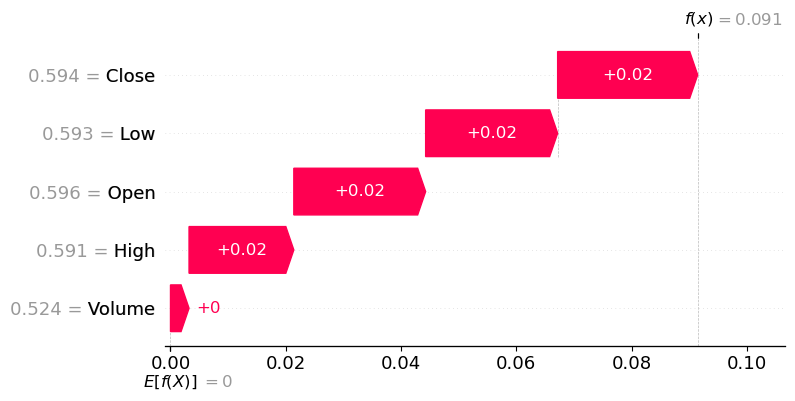

SHAP Force plot for same point


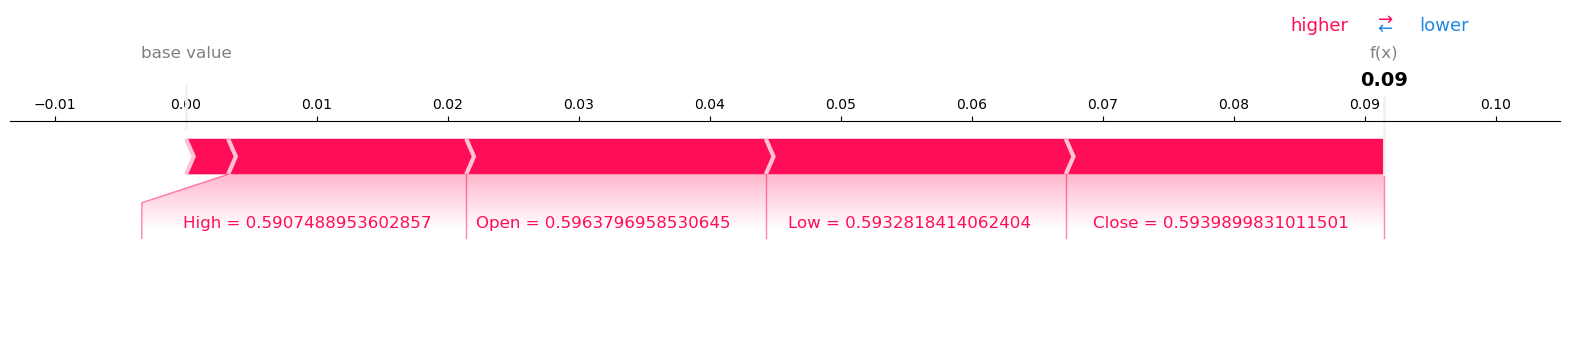

SHAP summary plot for all test samples


/var/folders/w1/df7hx6js59d7w265m0l82k800000gn/T/ipykernel_35900/4240415217.py:47: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


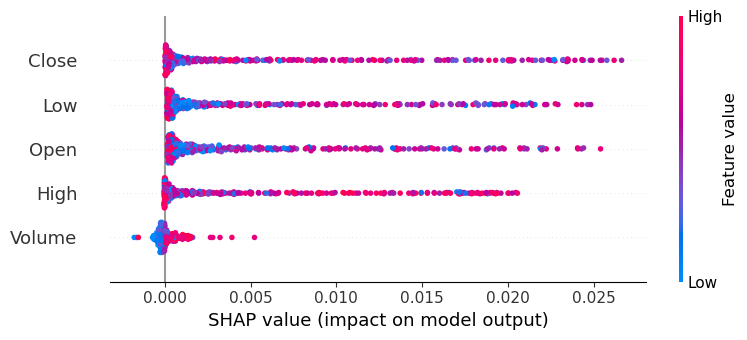

SHAP heatmap for one prediction sequence


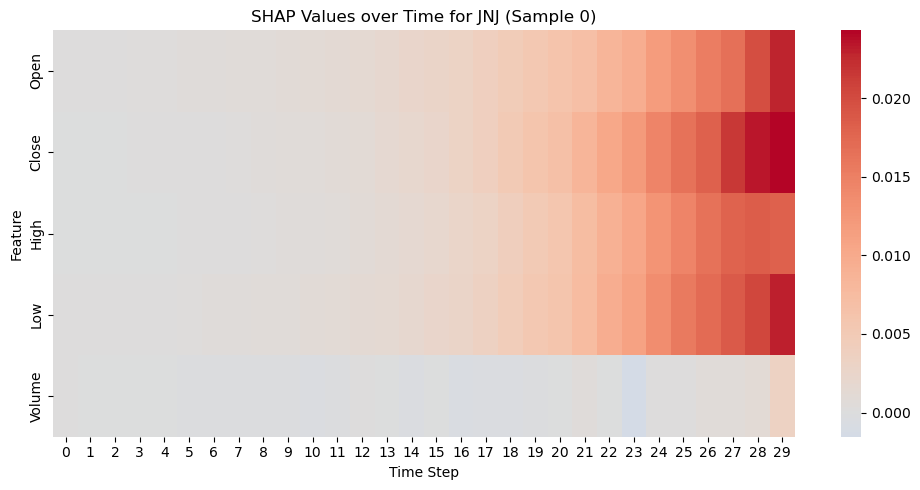


Visualizing SHAP for NVDA...
SHAP Waterfall plot (LSTM)


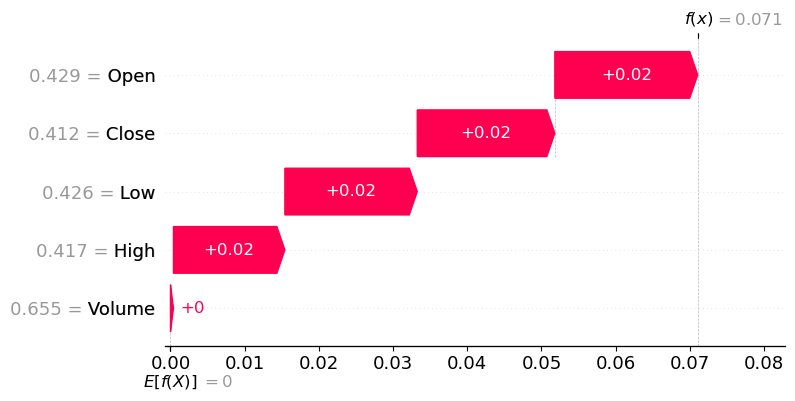

SHAP Force plot for same point


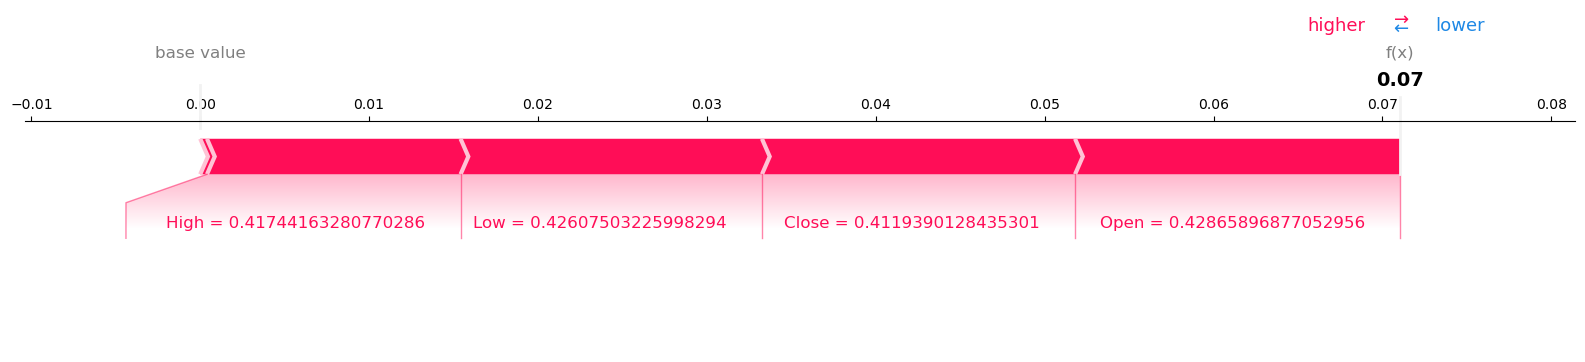

SHAP summary plot for all test samples


/var/folders/w1/df7hx6js59d7w265m0l82k800000gn/T/ipykernel_35900/4240415217.py:47: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


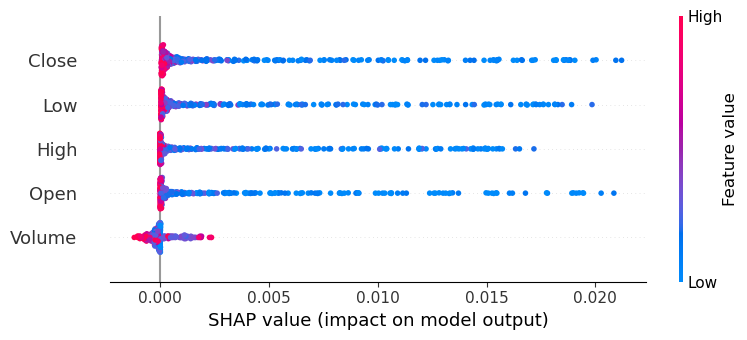

SHAP heatmap for one prediction sequence


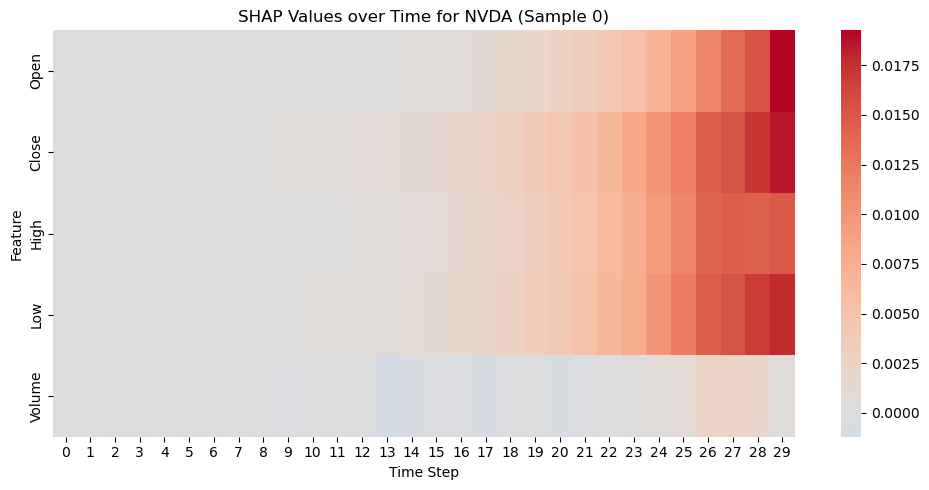


Visualizing SHAP for META...
SHAP Waterfall plot (LSTM)


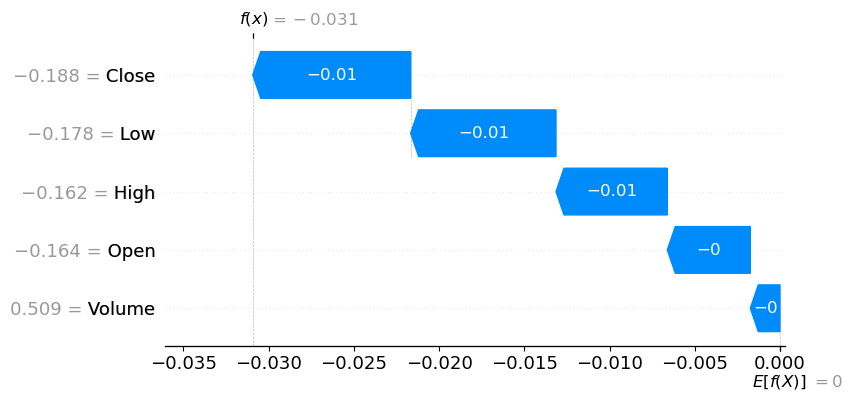

SHAP Force plot for same point


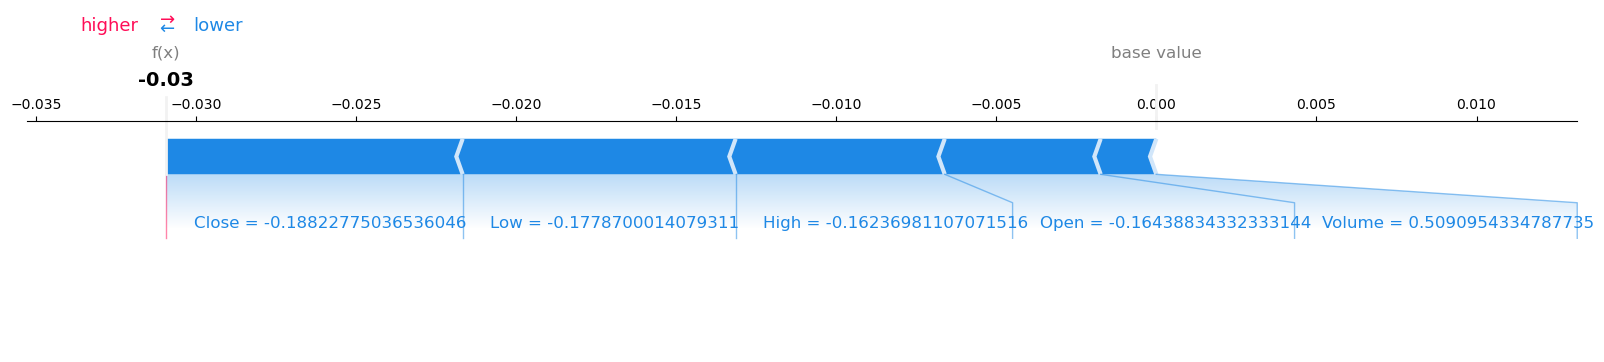

SHAP summary plot for all test samples


/var/folders/w1/df7hx6js59d7w265m0l82k800000gn/T/ipykernel_35900/4240415217.py:47: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


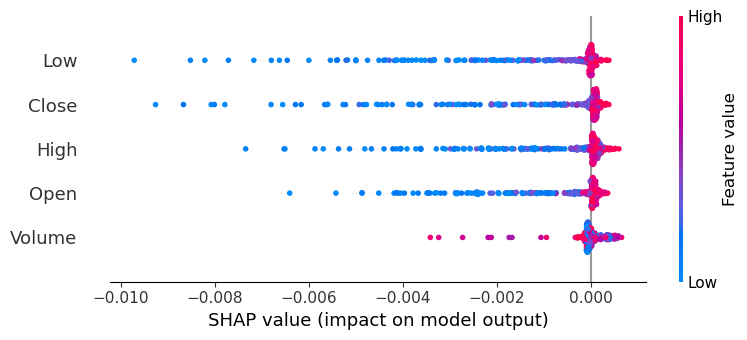

SHAP heatmap for one prediction sequence


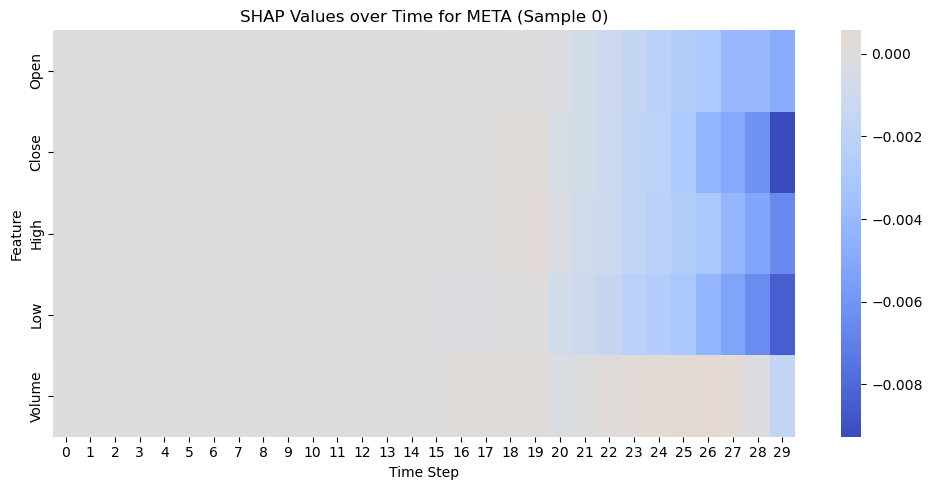


Visualizing SHAP for GOOGL...
SHAP Waterfall plot (LSTM)


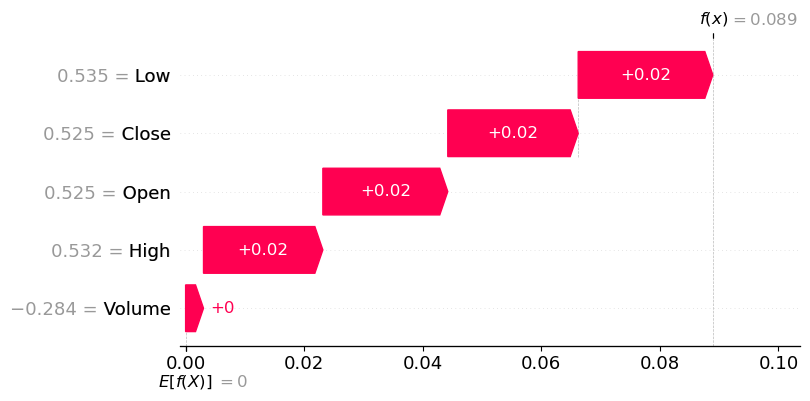

SHAP Force plot for same point


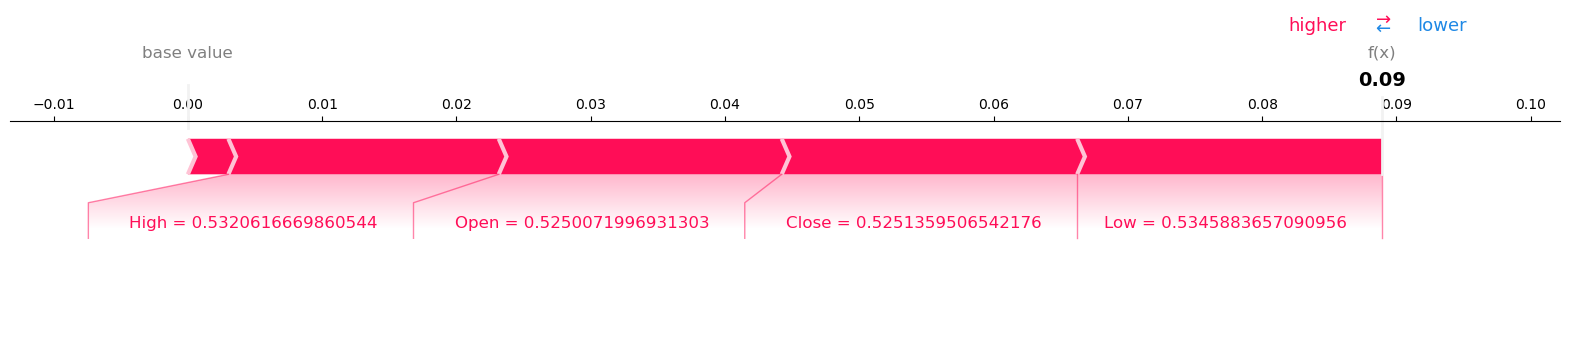

SHAP summary plot for all test samples


/var/folders/w1/df7hx6js59d7w265m0l82k800000gn/T/ipykernel_35900/4240415217.py:47: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


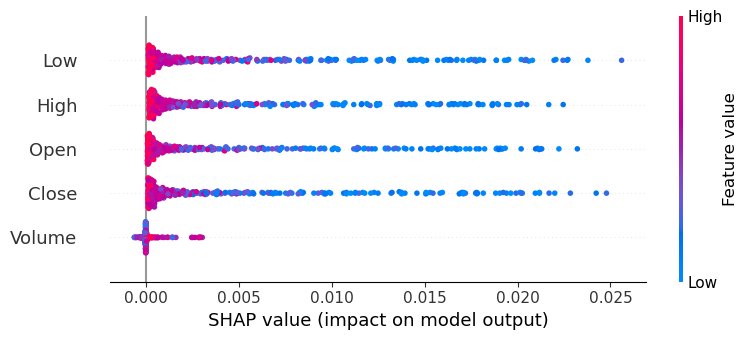

SHAP heatmap for one prediction sequence


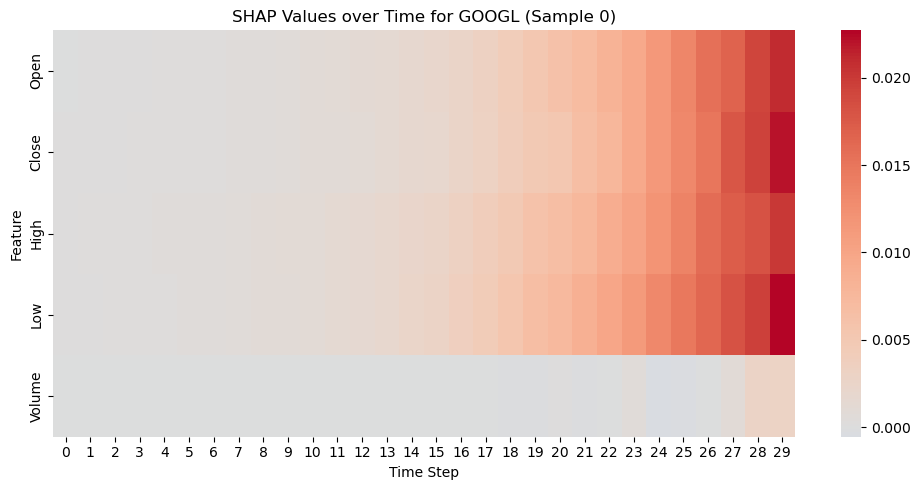

In [ ]:
# Initialize SHAP JS renderer
shap.initjs()

for ticker in tickers_list:
    print(f"\nVisualizing SHAP for {ticker}...")

    # Load data
    X_test = X_test_sets[ticker]
    shap_vals = shap_values[ticker]  # shape: (samples, timesteps, features)
    feature_names = included_features  # ['Open', 'Close', 'High', 'Low', 'Volume']

    # --- Waterfall plot for last timestep of a sample ---
    print("SHAP Waterfall plot (LSTM)")

    sample_idx = 0
    timestep = -1  # Last timestep

    # Get 1D SHAP and feature values for this point
    shap_1d = shap_vals[sample_idx][timestep]       # shape: (features,)
    features_1d = X_test[sample_idx][timestep]       # shape: (features,)

    # Wrap into a SHAP Explanation object to use with waterfall plot
    expl = shap.Explanation(
        values=shap_1d,
        base_values=0,  # optional: set to your model's base prediction if known
        data=features_1d,
        feature_names=feature_names
    )

    shap.plots.waterfall(expl, max_display=len(feature_names))

    # --- Force plot for same timestep ---
    print("SHAP Force plot for same point")

    shap.force_plot(
        base_value=0,
        shap_values=shap_1d,
        features=features_1d,
        feature_names=feature_names,
        matplotlib=True
    )

    # --- SHAP Summary plot for all test samples ---
    print("SHAP summary plot for all test samples")
    num_samples = shap_vals.shape[0]

    shap.summary_plot(
        shap_vals.reshape(-1, shap_vals.shape[-1]),
        features=X_test[:num_samples].reshape(-1, X_test.shape[-1]),
        feature_names=feature_names
    )

    # --- SHAP Heatmap over time for one sequence ---
    print("SHAP heatmap for one prediction sequence")

    plt.figure(figsize=(10, 5))
    sns.heatmap(
        shap_vals[sample_idx].T,
        xticklabels=True,
        yticklabels=feature_names,
        cmap='coolwarm',
        center=0
    )
    plt.title(f'SHAP Values over Time for {ticker} (Sample {sample_idx})')
    plt.xlabel('Time Step')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

In [ ]:
window_size = 30  # same as your LSTM input length
sample_idx = 0    # pick any sequence to explain

for ticker in tickers_list:
    print(f"\n[Stationary WindowSHAP] for {ticker}")

    # Get model, data, SHAP explainer
    model = models[ticker]
    X_test = X_test_sets[ticker]  # shape: (samples, timesteps, features)
    feature_names = included_features
    input_sample = X_test[sample_idx]  # shape: (30, 5)

    # --- Stationary WindowSHAP-style SHAP explanation ---
    # Treat input window as a single "sample"
    input_window = input_sample.reshape(1, window_size, len(feature_names))  # shape: (1, 30, 5)

    # Create a SHAP explainer for LSTM (DeepExplainer or GradientExplainer preferred)
    masker = shap.maskers.Independent(X_test[:50])
    explainer = shap.GradientExplainer(model, masker)

    print("Computing SHAP values for one sample window...")
    shap_vals_window = explainer(input_window)  # shape: (1, 30, 5)

    # Pull out values for visualization
    shap_vals_array = shap_vals_window.values[0]   # shape: (30, 5)
    features_array = input_window[0]               # shape: (30, 5)

    # ---- Waterfall Plot: Last timestep in the window ----
    print("Waterfall plot for last timestep of the input window")
    timestep = -1
    shap_1d = shap_vals_array[timestep]        # shape: (5,)
    features_1d = features_array[timestep]     # shape: (5,)

    expl = shap.Explanation(
        values=shap_1d,
        base_values=0,
        data=features_1d,
        feature_names=feature_names
    )

    shap.plots.waterfall(expl, max_display=len(feature_names))

    # ---- Force Plot for the same timestep ----
    print("Force plot")
    shap.force_plot(
        base_value=0,
        shap_values=shap_1d,
        features=features_1d,
        feature_names=feature_names,
        matplotlib=True
    )

    # ---- Summary Plot over full window ----
    print("Summary plot across all timesteps in the window")
    shap.summary_plot(
        shap_vals_array, features_array, feature_names=feature_names
    )

    # ---- SHAP Heatmap over Time ----
    print("SHAP heatmap over full input window")

    plt.figure(figsize=(10, 5))
    sns.heatmap(
        shap_vals_array.T,
        xticklabels=True,
        yticklabels=feature_names,
        cmap='coolwarm',
        center=0
    )
    plt.title(f'Stationary WindowSHAP Heatmap ({ticker}) - Sample {sample_idx}')
    plt.xlabel('Time Step')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()



[Stationary WindowSHAP] for JNJ
Computing SHAP values for one sample window...


TypeError: 'Independent' object is not subscriptable